In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import datetime

import warnings
warnings.filterwarnings("ignore")

# data observation

In [30]:
train = pd.read_csv('train_users_2.csv')
test = pd.read_csv('test_users.csv')
sessions = pd.read_csv('sessions.csv')
print(train.shape, test.shape, sessions.shape)

(213451, 16) (62096, 15) (10567737, 6)


In [31]:
train.columns  #train比test多一个country_destination字段（即我们需要预测的内容）

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [32]:
train.info()  #date_first_booking, age, first_affiliate_tracked有缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [33]:
train.isnull().sum() / len(train)  #date_first_booking 58%的缺失值，考虑是否删掉？ age有没有什么方法填充？assumption不同年龄段的人有不同的旅游目的地倾向

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

# time observation

In [34]:
df_train = train.copy()
df_test = test.copy()
df_sessions = sessions.copy()

In [35]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['date_first_active'] = pd.to_datetime((df_train.timestamp_first_active // 1000000), format='%Y%m%d')
df_train['date_first_booking'] = pd.to_datetime(df_train['date_first_booking'])
time_btw_dac_dfb = df_train['date_first_booking'] - df_train['date_account_created']
time_btw_tfa_dfb = df_train['date_first_booking'] - df_train['date_first_active']
print('---Time between Date Account Created and First Booking---')
print(time_btw_dac_dfb.describe())
print('---Time between Date First Active and First Booking---')
print(time_btw_tfa_dfb.describe())

---Time between Date Account Created and First Booking---
count                      88908
mean     44 days 08:41:59.854231
std      87 days 11:59:22.090141
min          -349 days +00:00:00
25%              1 days 00:00:00
50%              3 days 00:00:00
75%             29 days 00:00:00
max            365 days 00:00:00
dtype: object
---Time between Date First Active and First Booking---
count                      88908
mean     44 days 16:36:44.022135
std      88 days 11:35:12.574019
min              0 days 00:00:00
25%              1 days 00:00:00
50%              3 days 00:00:00
75%             29 days 00:00:00
max           1369 days 00:00:00
dtype: object


In [36]:
#median是3，mean是44，很明显的long tail分布(a very skewed distribution), 会存在很多outlier

In [37]:
df_train['date_account_created_weekname'] = df_train['date_account_created'].dt.weekday_name
df_train['date_account_created_year'] = df_train['date_account_created'].dt.year
df_train['date_account_created_month'] = df_train['date_account_created'].dt.month
df_train['date_account_created_day'] = df_train['date_account_created'].dt.day

In [38]:
df_train['date_first_active_weekname'] = df_train['date_first_active'].dt.weekday_name
df_train['date_first_active_year'] = df_train['date_first_active'].dt.year
df_train['date_first_active_month'] = df_train['date_first_active'].dt.month
df_train['date_first_active_day'] = df_train['date_first_active'].dt.day

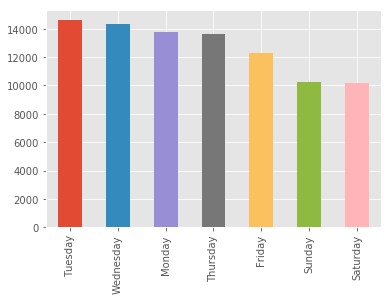

In [39]:
#date_account_created在Thuesday的booking的几率大, weekend几率小
df_train[df_train['country_destination'] != 'NDF'].date_account_created_weekname.value_counts().plot(kind='bar')

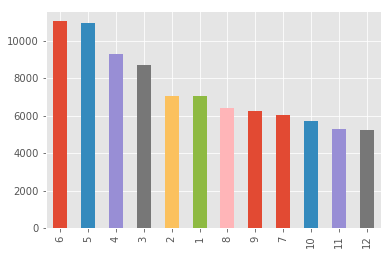

In [40]:
#date_account_created在6,5月份注册得多
df_train[df_train['country_destination'] != 'NDF'].date_account_created_month.value_counts().plot(kind='bar')

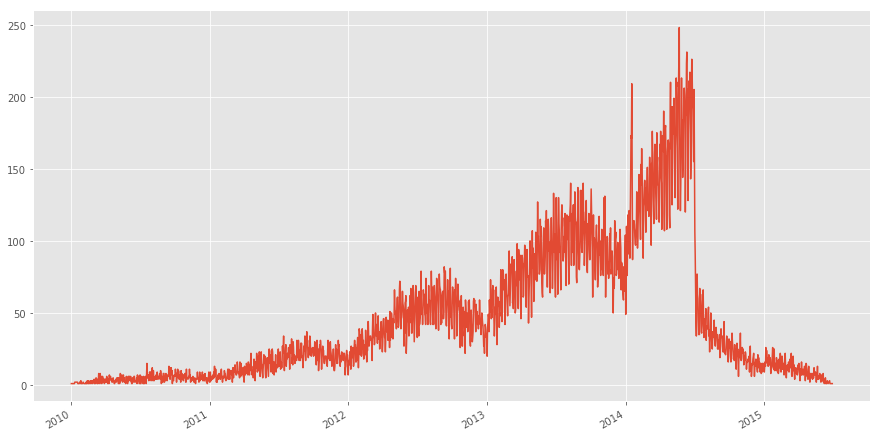

In [41]:
fig,ax = plt.subplots(figsize=(15,8))  #2014年是否有数据缺失，基本在7、8、9月份booking都会增加
df_train[df_train['country_destination'] != 'NDF'].date_first_booking.value_counts().plot()

# age observation

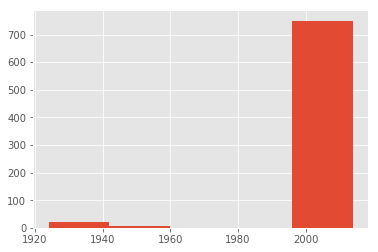

In [42]:
#age中存在一些类似年份的错误值，是否能手动更正？还有一些100多岁的？还有一些小于16岁的？有身份证么？可以注册住宿么？
df_train[df_train.age > 1000].age.hist(bins=5)

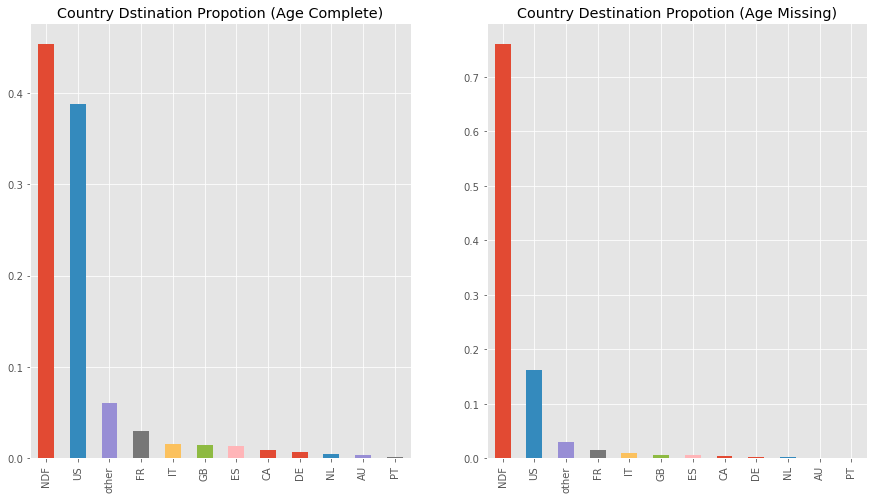

In [43]:
#competition的时候是2015，1920年出生的是95岁，2000年出生的是15岁
av = df_train.age.values
df_train['age'] = np.where(np.logical_and(av>1920, av<2000), 2015-av, av)
df_train['age'] = np.where(np.logical_or(av>100, av<18), np.nan, av)

fix,axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
complete_age = df_train[df_train.age.notnull()].country_destination.value_counts()
missing_age = df_train[df_train.age.isnull()].country_destination.value_counts()
complete_age.div(complete_age.sum()).plot(kind='bar', title='Country Dstination Propotion (Age Complete)', ax=axes[0])
missing_age.div(missing_age.sum()).plot(kind='bar', title='Country Destination Propotion (Age Missing)', ax=axes[1])

In [44]:
#不填年龄的，约75%不会booking

(10, 60)

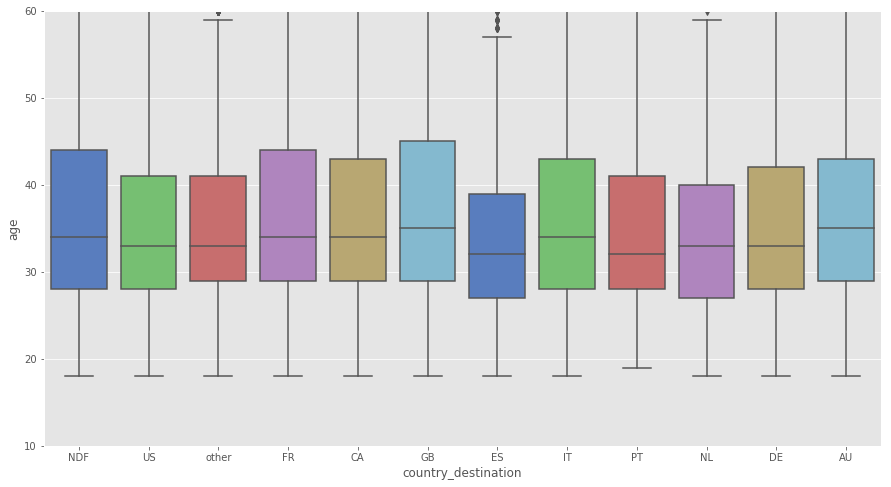

In [45]:
import seaborn as sns  #年龄大一些的倾向于去GB，年轻一些的喜欢去ES
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax)
ax.set_ylim([10, 60])

# country_destination observation

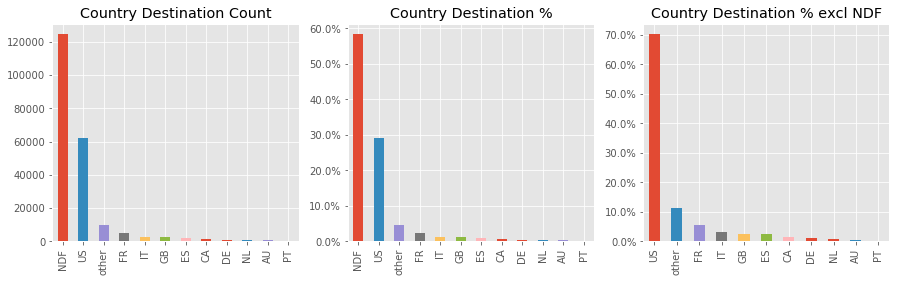

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 4))
country_counts = df_train.country_destination.value_counts()
country_counts.plot(kind='bar',title='Country Destination Count',ax=axes[0])
ax = country_counts.div(country_counts.sum()).plot(kind='bar',title='Country Destination %',ax=axes[1] )
ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax.get_yticks()])
booked_count = df_train[df_train.country_destination != 'NDF'].country_destination.value_counts()
ax1 = booked_count.div(booked_count.sum()).plot(kind='bar',title='Country Destination % excl NDF',ax=axes[2] )
ax1.set_yticklabels(['{:3.1f}%'.format(x*100) for x in ax1.get_yticks()])

In [47]:
#不预定的占比接近60%，除去NDF，US占比接近70%，是不是跟语言有关？去英语为主要语种的地方？

# categorical observation

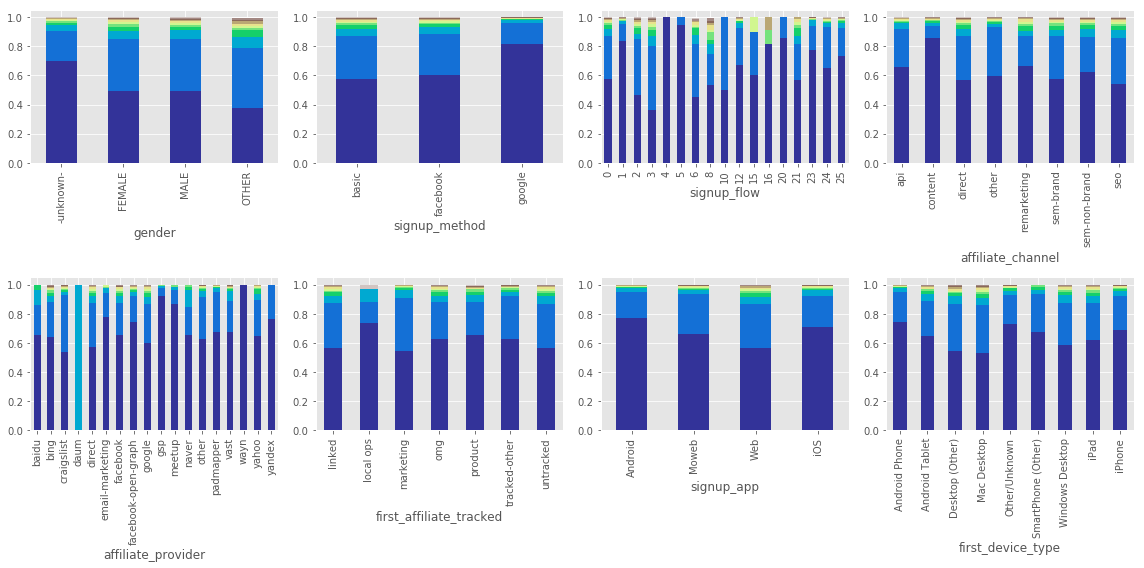

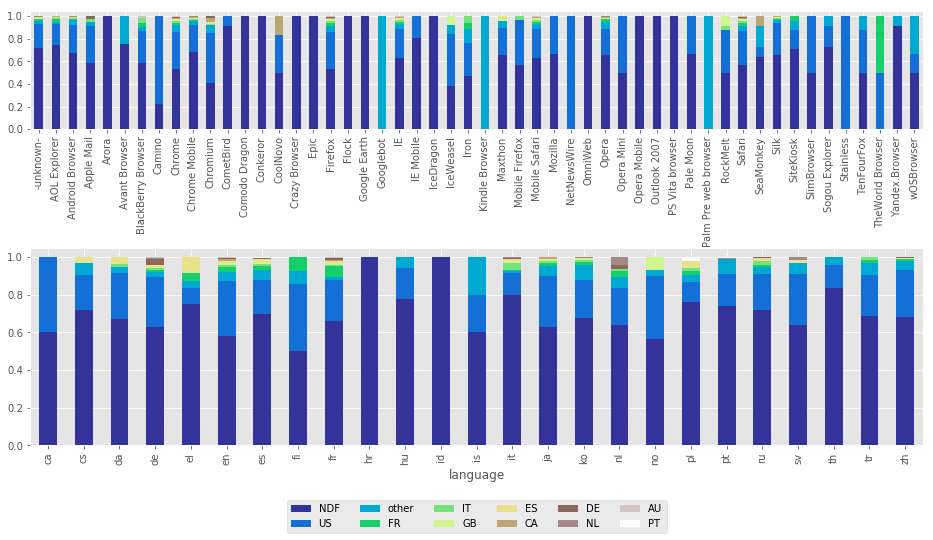

In [48]:
bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
cat_vars = ['gender', 'signup_method', 'signup_flow', 'affiliate_channel', 'affiliate_provider', 
            'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'language']
from matplotlib.colors import Colormap
fig, ax4 = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
def pltCatVar(var,axis,ax_num):
    ctab = pd.crosstab([df_train[var]], df_train.country_destination).apply(lambda x: x/x.sum(), axis=1)
    ctab[bar_order].plot(kind='bar', stacked=True, ax=axis.reshape(-1)[ax_num],legend=False, 
                         colormap='terrain')
for i,var in enumerate(cat_vars[:8]):
    pltCatVar(var,ax4,i)
plt.tight_layout()
fig, ax5 = plt.subplots(nrows=2, ncols=1, figsize=(16, 8), sharey=True)
for i,var in enumerate(cat_vars[8:]):
    pltCatVar(var,ax5,i)
box = ax5[0].get_position()
ax5[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
ax5[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=6)

In [49]:
#gender -unknown- 的人容易NDF  男女数据比较均衡
#signup_method google的人容易NDF
#signup_flow为3 的人容易booking
#affiliate_channel 为 content的人容易NDF
#affiliate_provider 为 craigslist的人容易booking
#first_affiliate_tracked 为 ops 的人容易 NDF
#signup_app 为web 更容易booking
#first_device_type 为 Mac desktop 更容易booking
#language 为 hr，id等容易 NDF， en，fi容易 booking

# feature extraction

In [50]:
#df_train['country_destination'] 作为训练集的label，除了NDF之外，70%待在美国，数据imbalance
#time 拆分年、月、日更有代表性，关注美国大型节日（比如元旦（1.1）独立日（7.4）劳工节（9月第一个星期一）感恩节（11月第四个星期四）圣诞节（12.25）
#age 不填的NDF，填的age大小对目的地有影响
#gender 不填的NDF，填的男女对目的地影响不大

In [51]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(df_train, test_size=0.2, random_state=42)
print(train_set.shape, test_set.shape)

(170760, 25) (42691, 25)


In [52]:
train_set.isnull().sum()

id                                   0
date_account_created                 0
timestamp_first_active               0
date_first_booking               99700
gender                               0
age                              72419
signup_method                        0
signup_flow                          0
language                             0
affiliate_channel                    0
affiliate_provider                   0
first_affiliate_tracked           4916
signup_app                           0
first_device_type                    0
first_browser                        0
country_destination                  0
date_first_active                    0
date_account_created_weekname        0
date_account_created_year            0
date_account_created_month           0
date_account_created_day             0
date_first_active_weekname           0
date_first_active_year               0
date_first_active_month              0
date_first_active_day                0
dtype: int64

In [53]:
y_train = train_set['country_destination']
y_test = test_set['country_destination']

train_set.drop(['date_first_booking', 'date_account_created', 'date_first_active', 'country_destination','id','timestamp_first_active','first_browser'], axis=1, inplace=True)
test_set.drop(['date_first_booking', 'date_account_created', 'date_first_active', 'country_destination','id','timestamp_first_active','first_browser'], axis=1, inplace=True)

In [54]:
age_median = train_set['age'].median()
train_set['age'].fillna(age_median, inplace=True)
test_set['age'].fillna(age_median, inplace=True) #test是否应该跟train使用同一值补缺失

In [55]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170760 entries, 139642 to 121958
Data columns (total 18 columns):
gender                           170760 non-null object
age                              170760 non-null float64
signup_method                    170760 non-null object
signup_flow                      170760 non-null int64
language                         170760 non-null object
affiliate_channel                170760 non-null object
affiliate_provider               170760 non-null object
first_affiliate_tracked          165844 non-null object
signup_app                       170760 non-null object
first_device_type                170760 non-null object
date_account_created_weekname    170760 non-null object
date_account_created_year        170760 non-null int64
date_account_created_month       170760 non-null int64
date_account_created_day         170760 non-null int64
date_first_active_weekname       170760 non-null object
date_first_active_year           170760 non-nul

In [56]:
category = ['gender','signup_method','signup_flow','language','affiliate_channel','affiliate_provider','first_affiliate_tracked',
           'signup_app','first_device_type','date_account_created_weekname','date_first_active_weekname']

for f in category:
    train_set_dummies = pd.get_dummies(train_set[f], prefix=f)
    train_set.drop([f], axis=1, inplace=True)
    train_set = pd.concat((train_set, train_set_dummies), axis=1)
train_set.head()

,age,date_account_created_year,date_account_created_month,date_account_created_day,date_first_active_year,date_first_active_month,date_first_active_day,gender_-unknown-,gender_FEMALE,gender_MALE,...,date_account_created_weekname_Thursday,date_account_created_weekname_Tuesday,date_account_created_weekname_Wednesday,date_first_active_weekname_Friday,date_first_active_weekname_Monday,date_first_active_weekname_Saturday,date_first_active_weekname_Sunday,date_first_active_weekname_Thursday,date_first_active_weekname_Tuesday,date_first_active_weekname_Wednesday
139642,31.0,2014,1,9,2014,1,9,0,0,1,...,1,0,0,0,0,0,0,1,0,0
519,37.0,2010,5,4,2010,5,4,0,1,0,...,0,1,0,0,0,0,0,0,1,0
120664,34.0,2013,10,30,2013,10,30,1,0,0,...,0,0,1,0,0,0,0,0,0,1
84733,34.0,2013,6,18,2013,6,18,1,0,0,...,0,1,0,0,0,0,0,0,1,0
183255,28.0,2014,5,1,2014,5,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0


In [57]:
y_train.head()

139642     US
519        US
120664    NDF
84733     NDF
183255     US
Name: country_destination, dtype: object

In [58]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train.values)

# prepare data

In [60]:
# Let us take 10% of the data for faster training. 
n = int(train_set.shape[0]*0.1)
X_train = train_set.iloc[:n, :]  #训练数据
y_train = y_train_le[:n]       #训练数据的目标变量

In [ ]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)

# measure model

In [61]:
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):

    """
    y_true : array, shape = [n_samples] #数据
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes] #预测的分数
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1] #分数从高到低排序
    y_true = np.take(y_true, order[:k]) #取出前k[0,k）个分数

    gain = 2 ** y_true - 1   

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):   

    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes] 
        Predicted probabilities. 预测的概率
    k : int
        Rank.
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)    
    scores = []
    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=600,criterion='gini')
rf = rf.fit(X_train,y_train)